In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.stats import kurtosis, skew
from scipy.io import loadmat
from scipy.signal import resample
import seaborn as sns
import os
from tqdm import tqdm

palette = ["#024059", "#0388A6", "#8C031C"]
sns.set_palette(sns.color_palette(palette))

In [ ]:
def load_data(f, type):
    data = loadmat(f)
    if type == 'ann':
        data = data['labels']
    elif type == 'spk':
        data = data['speaks']
    elif type == 'ppg':
        data = data['ppg']

    return data

# Insert path of files containing the signals
input_directory ='train'

print('Loading data...')

# Sort the files in the folder wrt the name
os.listdir(input_directory).sort()


annotations_files = []
spk_files = []
ppg_files = []
sampling_frequencies = []

# Get name of header files contained in the folder
for f in os.listdir(input_directory):
    g = os.path.join(input_directory, f)

    # Extract the first 4 chars of the file name
    chars = g[7:10]
    idx = int(chars)

    if '_ann' in g:
        annotations_files.append({'idx': idx, 'annot': g})
    elif '_spk' in g:
        spk_files.append({'idx': idx, 'spk': g})
    else:
        ppg_files.append({'idx': idx, 'ppg': g})
        # Save the sampling frequency of the signal only one time
        if '128' in g:
            sampling_frequencies.append(128)
        elif '250' in g:
            sampling_frequencies.append(250)

# Get dataframes from lists
annotations_files = pd.DataFrame(annotations_files)
spk_files = pd.DataFrame(spk_files)
ppg_files = pd.DataFrame(ppg_files)

# Sort dataframes wrt the index
annotations_files = annotations_files.sort_values(by=['idx'])
spk_files = spk_files.sort_values(by=['idx'])
ppg_files = ppg_files.sort_values(by=['idx'])

# Create empty list for data
annotations = []
spk = []
ppg = []

# Load data into variables
for a in annotations_files['annot']:
    annotation = load_data(a, type='ann')
    annotation = np.array(annotation)
    annotations.append(annotation)

for a in spk_files['spk']:
    spk_data = load_data(a, type='spk')
    spk_data = np.array(spk_data)
    spk.append(spk_data)
    # transform to array the spk data

for a in ppg_files['ppg']:
    ppg_data = load_data(a, type='ppg')
    ppg_data = np.array(ppg_data)
    ppg.append(ppg_data)

print('Done')

Loading data...
Done


# Preprocessing

In [ ]:
# Outputs of the two autoencoders !!!
ppg_autoencoder_128 = pd.read_csv("Dataset/ppg_cleaned_128_2.csv")
ppg_autoencoder_250 = pd.read_csv("Dataset/ppg_cleaned_250_2.csv")

In [ ]:
ppg_auto_128 = []
for i in range(len(ppg_autoencoder_128)):
    nan_mask = np.isnan(ppg_autoencoder_128.iloc[i,:])
    ppg_auto_128.append(np.array(ppg_autoencoder_128.loc[i,~nan_mask]))

ppg_auto_250 = []
for i in range(len(ppg_autoencoder_250)):
    nan_mask = np.isnan(ppg_autoencoder_250.iloc[i,:])
    ppg_auto_250.append(np.array(ppg_autoencoder_250.loc[i,~nan_mask]))

In [ ]:
spk = [np.squeeze(array) for array in spk]
ppg = [np.squeeze(array) for array in ppg]

In [ ]:
def find_consecutive_zeros(signal, max_consecutive=20):
    max_length = 0
    temp_length = 0

    for t in signal:
        if t == 0:
            temp_length+=1
        else:
            temp_length = 0
        if temp_length > max_length:
            max_length = temp_length

    return max_length < max_consecutive

def filter_signal(signal_ppg, fs, lowcut=0.1, highcut=7):
    # Define the filter parameters (from the Chebyshev filter)

    nyquist_freq = 0.5 * fs          # Nyquist frequency in Hz
    low = lowcut / nyquist_freq      # Low cut frequency in Hz
    high = highcut / nyquist_freq    # High cut frequency in Hz

    order = 3  # Filter order

    #Create filter for the signal
    b, a = butter(order, [low, high], btype="band")

    # Apply the filter to the signal
    y = lfilter(b, a, signal_ppg)

    return y

def min_max_scaling(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)

    scaled_signal = (signal - min_val) / (max_val - min_val)

    return scaled_signal

def abs_difference_skew(signal1, signal2):
    skew1 = skew(signal1)
    skew2 = skew(signal2)
    return np.abs(skew2 - skew1)

def abs_difference_kurt(signal1, signal2):
    kurt1 = kurtosis(signal1)
    kurt2 = kurtosis(signal2)
    return np.abs(kurt2 - kurt1)


def preprocessing(ppg_auto, ppg_raw, spk, ann, window, fs, dik_max, dip_max, dia_max, undersample=False, under_window=None, upper_fs=None):

    # Initial checks
    if not (len(ppg_raw) == len(spk) == len(ann) == len(ppg_auto)):
        raise ValueError('ppg_auto, ppg_raw, spk, ann params must have the same length')
    if window%2 != 0:
        raise ValueError('Window must be even')

    signals = []
    grad_signals = []
    y = []
    features = []
    maps_idx = []

    half_window = int(window/2)
    start_idx = int(half_window - int(half_window/3))
    end_idx = int(half_window + int(half_window/3))

    for signal_idx in tqdm(np.arange(len(ppg_auto))):

        for peak_idx in np.arange(len(spk[signal_idx])):

            ind_min = spk[signal_idx][peak_idx] - start_idx
            ind_max = spk[signal_idx][peak_idx] + end_idx
            signal = ppg_auto[signal_idx][ind_min:ind_max]

            if len(signal)<window:
                continue

            # Check that signal is not an outlier
            sig_max = np.max(signal)

            if find_consecutive_zeros(signal) and sig_max<3.5:

                # Dealing with first and last peaks of the signal
                pre_offset = 0
                post_offset = 0
                if peak_idx == 0:
                    pre_offset = 2
                elif peak_idx == (len(spk[signal_idx])-1):
                    post_offset = -2

                # Differences between peaks distance
                dip_pre = np.abs(spk[signal_idx][peak_idx] - spk[signal_idx][peak_idx-1+pre_offset])
                dip_post = np.abs(spk[signal_idx][peak_idx+1+post_offset] - spk[signal_idx][peak_idx])
                if dip_pre>dip_max or dip_post>dip_max:
                    continue

                # Difference between peaks amplitude
                dia_pre = np.abs(ppg_raw[signal_idx][spk[signal_idx][peak_idx-1+pre_offset]] - ppg_raw[signal_idx][spk[signal_idx][peak_idx]])
                dia_post = np.abs(ppg_raw[signal_idx][spk[signal_idx][peak_idx+1+post_offset]] - ppg_raw[signal_idx][spk[signal_idx][peak_idx]])
                if dia_pre>dia_max or dia_post>dia_max:
                    continue

                # Get previous and next peaks
                ind_min_pre = spk[signal_idx][peak_idx-1+pre_offset] - start_idx
                ind_max_pre = spk[signal_idx][peak_idx-1+pre_offset] + end_idx
                pre_signal = ppg_raw[signal_idx][ind_min_pre:ind_max_pre]

                ind_min_post = spk[signal_idx][peak_idx+1+post_offset] - start_idx
                ind_max_post = spk[signal_idx][peak_idx+1+post_offset] + end_idx
                post_signal = ppg_raw[signal_idx][ind_min_post:ind_max_post]

                # Downsample from a window of 250 to a window of 125
                if undersample:
                    window = under_window
                    dip_pre = dip_pre / (upper_fs/fs)
                    dip_post = dip_post / (upper_fs/fs)
                    signal = resample(signal, under_window)
                    pre_signal = resample(pre_signal, under_window)
                    post_signal = resample(post_signal, under_window)


                # Apply filter to signals
                signal = filter_signal(signal, fs)
                pre_signal = filter_signal(pre_signal, fs)
                post_signal = filter_signal(post_signal,fs)

                # MinMaxScaler to each signal
                signal = min_max_scaling(signal)
                pre_signal = min_max_scaling(pre_signal)
                post_signal = min_max_scaling(post_signal)

                # Differences of skewness and kurtosis
                dik_pre = abs_difference_kurt(pre_signal, signal)
                dik_post = abs_difference_kurt(signal, post_signal)
                if dik_pre>dik_max or dik_post>dik_max:
                    continue

                dis_pre = abs_difference_skew(pre_signal, signal)
                dis_post = abs_difference_skew(signal, post_signal)

                # Calculate derivative of signal
                signal_grad = np.gradient(signal)

                # Append all results
                feats = np.array([dik_pre, dik_post, dis_pre, dis_post, dip_pre, dip_post, dia_pre, dia_post])
                maps_temp = [signal_idx, peak_idx]

                features.append(feats)
                signals.append(signal)
                grad_signals.append(signal_grad)
                maps_idx.append(maps_temp)
                y.append(ann[signal_idx][peak_idx])

    signals = np.array(signals).reshape((len(signals), window, 1))
    grad_signals = np.array(grad_signals).reshape((len(grad_signals), window, 1))
    X = np.concatenate((signals, grad_signals), axis=2)
    y = np.array(y).reshape((len(y), 1))
    features = np.array(features)
    maps_idx = np.array(maps_idx)

    return X, features, y, maps_idx


In [ ]:
X_128, features_128, y_128, maps_idx_128 = preprocessing(
    ppg_auto=ppg_auto_128,
    ppg_raw=ppg[:62],
    spk=spk[:62],
    ann=annotations[:62],
    window=128,
    fs=128,
    dik_max=25,
    dia_max=55,
    dip_max=250
)

100%|██████████| 62/62 [01:59<00:00,  1.92s/it]


In [ ]:
X_128.shape, features_128.shape, y_128.shape, maps_idx_128.shape

((83384, 128, 2), (83384, 8), (83384, 1), (83384, 2))

In [ ]:
X_250, features_250, y_250, maps_idx_250 = preprocessing(
    ppg_auto=ppg_auto_250,
    ppg_raw=ppg[62:],
    spk=spk[62:],
    ann=annotations[62:],
    window=250,
    fs=128,
    dik_max=25,
    dia_max=55,
    dip_max=500,
    undersample=True,
    under_window=128,
    upper_fs=250
)

100%|██████████| 43/43 [00:49<00:00,  1.16s/it]


In [ ]:
X_250.shape, features_250.shape, y_250.shape, maps_idx_250.shape

((33688, 128, 2), (33688, 8), (33688, 1), (33688, 2))

In [ ]:
np.save("./Dataset/X_128_2", X_128, allow_pickle=True)
np.save("./Dataset/y_128_2", y_128, allow_pickle=True)
np.save("./Dataset/features_128_2", features_128, allow_pickle=True)
np.save("./Dataset/maps_idx_128_2", maps_idx_128, allow_pickle=True)

np.save("./Dataset/X_250_under_2", X_250, allow_pickle=True)
np.save("./Dataset/y_250_under_2", y_250, allow_pickle=True)
np.save("./Dataset/features_250_under_2", features_250, allow_pickle=True)
np.save("./Dataset/maps_idx_250_under_2", maps_idx_250, allow_pickle=True)

## Optional: check map

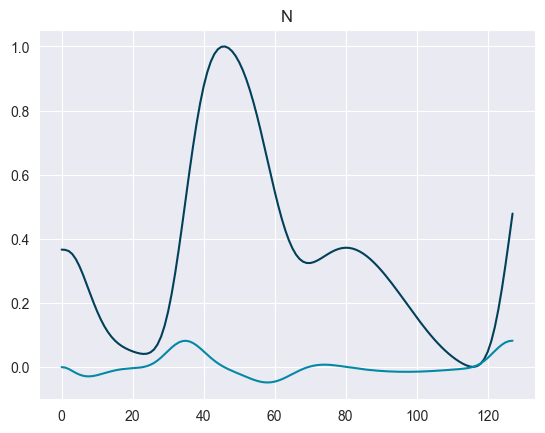

In [ ]:
sample_idx = 31342
plt.plot(np.arange(128), X_250[sample_idx,:,0])
plt.plot(np.arange(128), X_250[sample_idx,:,1])
plt.title(y_250[sample_idx][0])
plt.show()

In [ ]:
maps_idx_250[31342]

array([40, 30])

## Optional: find thresholds

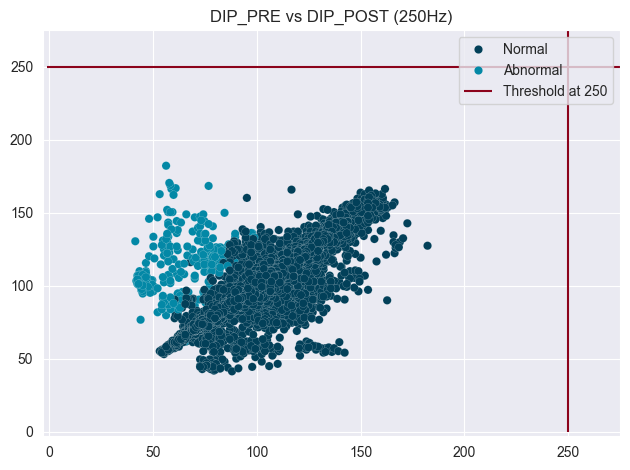

In [ ]:
colors= ['Normal' if l[0] == 'N' else 'Abnormal' for l in y_250]
sns.scatterplot(x=features_250[:,4], y=features_250[:,5], hue=colors, linewidth=0.1)
plt.hlines(250,-1,300, label="Threshold at 250", colors=palette[2])
plt.vlines(250,0,300, colors=palette[2])
plt.title("DIP_PRE vs DIP_POST (250Hz)")
plt.xlim(-3,275)
plt.ylim(-3,275)
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig("plots/DIP_PRE_DIP_POST_250.png", dpi=300)